# 5.2 Training a convnet from scratch on a small dataset

Having to train an image-classification model using very little data is a common situation, which you’ll likely encounter in practice if you ever do computer vision in a professional context. __A “few” samples can mean anywhere from a few hundred to a
few tens of thousands of images__. As a practical example, we’ll focus on classifying images as dogs or cats, in a dataset containing 4,000 pictures of cats and dogs (2,000 cats, 2,000 dogs). We’ll use 2,000 pictures for training—1,000 for validation, and 1,000 for testing.

In this section, we’ll review one basic strategy to tackle this problem: training a new model from scratch using what little data you have. You’ll start by naively training a small convnet on the 2,000 training samples, without any regularization, to set a baseline for what can be achieved. This will get you to a classification accuracy of 71%. At that point, the main issue will be overfitting. Then we’ll introduce __data augmentation__, a __powerful technique for mitigating overfitting in computer vision__. By using data augmentation, you’ll improve the network to reach an accuracy of 82%.

In the next section, we’ll review __two more essential techniques__ for applying deep learning to small datasets: __feature extraction with a pretrained network__ (which will get you to an accuracy of 90% to 96%) and __fine-tuning a pretrained network (this will get you to a final accuracy of 97%)__. Together, these __three strategies__—training a small model from scratch, doing feature extraction using a pretrained model, and fine-tuning a pretrained model—will constitute your future __toolbox for tackling the problem of performing image classification with small datasets__.

## 5.2.1 The relevance of deep learning for small-data problems

You’ll sometimes hear that deep learning only works when lots of data is available. This is valid in part: one fundamental __characteristic of deep learning__ is that it can __find interesting features in the training data on its own__, without any need for manual feature engineering, and this can only be achieved when lots of training examples are available. This is __especially true for problems where the input samples are very highdimensional, like images__.

But what __constitutes lots of samples is relative__—__relative to the size and depth of the network you’re trying to train__, for starters. It isn’t possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundred can potentially suffice if the model is small and well regularized and the task is simple. Because convnets learn local, translation-invariant features, they’re highly data efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results despite a relative lack of data, without the need for any custom
feature engineering. You’ll see this in action in this section.

What’s more, deep-learning models are by nature __highly repurposable__: __you can take__, say, an __image-classification__ or __speech-to-text model trained on a large-scale dataset__ and __reuse it on a significantly different problem with only minor changes__. Specifically, in the case of computer vision, many pretrained models (usually trained on the Image-Net dataset) are now publicly available for download and can be used to bootstrap powerful vision models out of very little data. That’s what you’ll do in the next section. Let’s start by getting your hands on the data.

## 5.2.2 Downloading the data

The Dogs vs. Cats dataset that you’ll use isn’t packaged with Keras. It was made available by Kaggle as part of a computer-vision competition in late 2013, back when convnets weren’t mainstream. You can download the original dataset from www.kaggle.com/c/dogs-vs-cats/data (you’ll need to create a Kaggle account if you don’t already have one—don’t worry, the process is painless).

Unsurprisingly, the __dogs-versus-cats Kaggle competition__ in 2013 was __won by entrants who used convnets__. The best entries achieved up to 95% accuracy. In this example, you’ll get fairly close to this accuracy (in the next section), even though you’ll train your models on less than 10% of the data that was available to the competitors.

This dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543 MB (compressed). After downloading and uncompressing it, you’ll create a new dataset containing three subsets: a training set with 1,000 samples of each class, a validation set with 500 samples of each class, and a test set with 500 samples of each class.

Following is the code to do this.

In [1]:
# Copying images to training, validation, and test directories
import os, shutil
from pathlib import Path

# Path to the directory where the original dataset was uncompressed
original_dataset_dir = os.listdir(Path.cwd())[len(os.listdir(Path.cwd()))-3]

# Directory where you’ll store your smaller dataset
base_dir = os.listdir(Path.cwd())[len(os.listdir(Path.cwd()))-2]

#os.mkdir(base_dir)

In [2]:
# Directories for the training,
# validation, and test splits

train_dir = os.path.join(base_dir, 'train')
#os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
#os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
#os.mkdir(test_dir)

In [3]:
# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
#os.mkdir(train_cats_dir)

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
#os.mkdir(train_dogs_dir)

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
#os.mkdir(validation_cats_dir)

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
#os.mkdir(validation_dogs_dir)

# Directory with test cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
#os.mkdir(test_cats_dir)

# Directory with test dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
#os.mkdir(test_dogs_dir)

In [4]:
# Copies the first 1,000 cat images to train_cats_dir
from sys import platform

if platform == "linux":
    train_prefix = original_dataset_dir + '/train/train/'
else:
    train_prefix = original_dataset_dir + '\\train\\train\\'

fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(train_prefix, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copies the next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(train_prefix, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copies the next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(train_prefix, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

In [5]:
# Copies the first 1,000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(train_prefix, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copies the next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(train_prefix, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copies the next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(train_prefix, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

As a sanity check, let’s count how many pictures are in each training split (train/validation/
test):

In [6]:
print('total training cat images:', len(os.listdir(train_cats_dir)))

total training cat images: 1000


In [7]:
print('total training dog images:', len(os.listdir(train_dogs_dir)))

total training dog images: 1000


In [8]:
print('total validation cat images:', len(os.listdir(validation_cats_dir)))

total validation cat images: 500


In [9]:
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total validation dog images: 500


In [10]:
print('total test cat images:', len(os.listdir(test_cats_dir)))

total test cat images: 500


In [11]:
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total test dog images: 500


So you do indeed have 2,000 training images, 1,000 validation images, and 1,000 test images. Each split contains the same number of samples from each class: this is a balanced __binary-classification problem__, which means classification accuracy will be an appropriate measure of success.

## 5.2.3 Building your network

You built a small convnet for MNIST in the previous example, so you should be familiar with such convnets. You’ll reuse the same general structure: the convnet will be a stack of alternated Conv2D (with relu activation) and MaxPooling2D layers.

But because you’re dealing with bigger images and a more complex problem, you’ll make your network larger, accordingly: it will have one more Conv2D + MaxPooling2D stage. This serves both __to augment the capacity of the network__ and __to further reduce the size of the feature maps__ so they aren’t overly large when you reach the Flatten layer. Here, because you start from inputs of size 150 × 150 (a somewhat arbitrary choice), you end up with feature maps of size 7 × 7 just before the Flatten layer.

NOTE The depth of the feature maps progressively increases in the network (from 32 to 128), whereas the size of the feature maps decreases (from 148 × 148 to 7 × 7). This is a pattern you’ll see in almost all convnets.

Because you’re attacking a binary-classification problem, you’ll end the network with a single unit (a Dense layer of size 1) and a sigmoid activation. This unit will encode the probability that the network is looking at one class or the other.

In [12]:
# Instantiating a small convnet for dogs vs. cats classification

from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


Let’s look at how the dimensions of the feature maps change with every successive layer:

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

For the compilation step, you’ll go with the RMSprop optimizer, as usual. Because you ended the network with a single sigmoid unit, you’ll use binary crossentropy as the
loss

In [14]:
from keras import optimizers

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

## 5.2.4 Data preprocessing

As you know by now, data should be formatted into appropriately preprocessed floatingpoint tensors before being fed into the network. Currently, the data sits on a drive as JPEG files, so the steps for getting it into the network are roughly as follows:
1. Read the picture files.
2. Decode the JPEG content to RGB grids of pixels.
3. Convert these into floating-point tensors.
4. Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but fortunately __Keras has utilities to take care of these steps automatically__. Keras has a module with image-processing helper tools, located at __keras.preprocessing.image__. In particular, it contains the class __ImageDataGenerator__, which lets you quickly set up Python generators that can automatically __turn image files on disk into batches of preprocessed tensors__. This is what you’ll use here.

In [15]:
# Using ImageDataGenerator to read images from directories
from keras.preprocessing.image import ImageDataGenerator

# Rescales all images by 1/255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150), # Resizes all images to 150 × 150
    batch_size=20,
    class_mode='binary' # Because you use binary_crossentropy loss, you need binary labels.
)

validation_generator = test_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150), # Resizes all images to 150 × 150
    batch_size=20,
    class_mode='binary' # Because you use binary_crossentropy loss, you need binary labels.
)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Let’s look at the output of one of these generators: it yields batches of 150 × 150 RGB images (shape (20, 150, 150, 3)) and binary labels (shape (20,)). There are 20 samples in each batch (the batch size). Note that the generator yields these batches indefinitely: it loops endlessly over the images in the target folder. For this reason, you need to break the iteration loop at some point:

In [16]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Fit the model :
1. Method: __fit_generator__ .
2. Argument : __train_data__ (as a __generator__).
3. Argument : __steps_per_epoch__ (Number of iteration per epochin train data).
4. Argument : __validation_data__ (as a __generator__).
5. Argument : __validation_steps__ (Number of iteration per epoch in validation data).

(1) Let’s fit the model to the data using the generator. You do so __using the fit_generator__ method, the equivalent of fit for __data generators__ like this one. 

(2) It expects as its first argument a Python generator that will yield batches of inputs and targets indefinitely, like this one does.

(3) Because the data is being generated endlessly, the Keras model needs to know how many samples to draw from the generator before declaring an epoch over (Number of iteration per epoch = __steps_per_epoch__).This is the role of the __steps_per_epoch__ argument: after having drawn __steps_per_epoch__ batches from the generator—that is, after having run for __steps_per_epoch__ gradient descent steps—the fitting process will go to the next epoch. In this case, batches are 20 samples, so it will take 100 batches until you see your target of 2,000 samples.(2,000 samples = 20 samples * 100 batches => __steps_per_epoch__ = __100__).

(4) When using fit_generator, you can pass a __validation_data__ argument, much as with the fit method. It’s important to note that this argument is allowed to be a data generator, but it could also be a tuple of Numpy arrays. 

(5) If you pass a generator as validation_data, then this generator is expected to yield batches of validation data endlessly; thus you should also specify the __validation_steps__ argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [17]:
# Fitting the model using a batch generator
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 70s 696ms/step - loss: 0.6874 - acc: 0.5360 - val_loss: 0.6659 - val_acc: 0.5960
Epoch 2/30
100/100 [==============================] - 65s 652ms/step - loss: 0.6621 - acc: 0.6015 - val_loss: 0.6828 - val_acc: 0.5460
Epoch 3/30
100/100 [==============================] - 66s 656ms/step - loss: 0.6295 - acc: 0.6335 - val_loss: 0.5790 - val_acc: 0.7250
Epoch 4/30
100/100 [==============================] - 65s 655ms/step - loss: 0.5889 - acc: 0.6850 - val_loss: 0.5363 - val_acc: 0.7440
Epoch 5/30
100/100 [==============================] - 66s 657ms/step - loss: 0.5490 - acc: 0.7165 - val_loss: 0.4992 - val_acc: 0.7580
Epoch 6/30
100/100 [==============================] - 66s 656ms/step - loss: 0.5232 - acc: 0.7360 - val_loss: 0.5591 - val_acc: 0.6860
Epoch 7/30
100/100 [==============================] - 66s 662ms/step - loss: 0.4966 - acc: 0.7590 - val_loss: 0.4513 - val_acc: 0.7810
Epoch 8

It’s good practice to always save your models after training.

In [18]:
# Saving the model
model.save('cats_and_dogs_small_1.h5')

Let’s plot the loss and accuracy of the model over the training and validation data during training

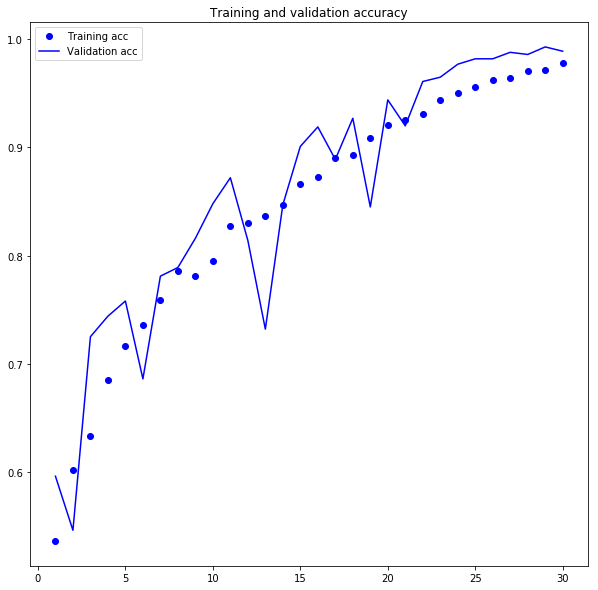

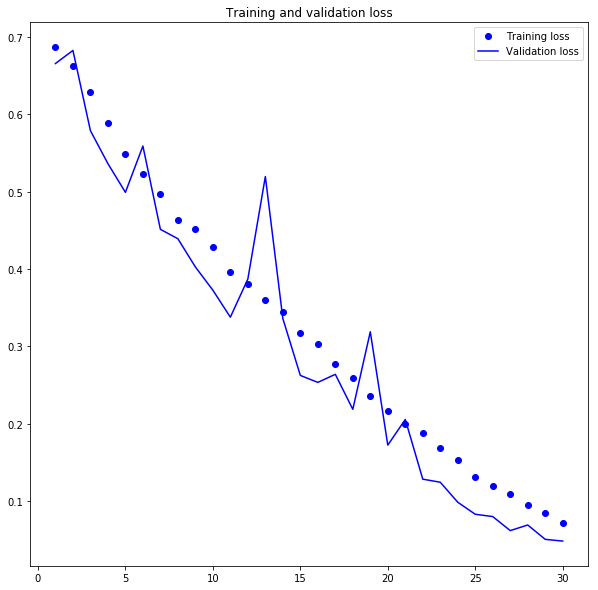

In [20]:
# Displaying curves of loss and accuracy during training
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 10))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(10, 10))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. The training accuracy increases linearly over time, until it reaches nearly 100%, whereas the validation accuracy stalls at 70–72%. The validation loss reaches its minimum after only five epochs and then stalls, whereas the training loss keeps decreasing linearly until it reaches nearly 0.

Because you have relatively few training samples (2,000), overfitting will be your number-one concern. You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We’re now
going to work with a new one, specific to computer vision and used almost universally when processing images with deep-learning models: __data augmentation__.

## 5.2.5 Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. Given infinite data, your model would be exposed to every possible aspect of the data distribution at hand: you would never overfit. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. Data augmentation takes the approach of generating more training data from existing training samples, by __augmenting__ the samples via a number of random
transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.
In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the __ImageDataGenerator__ instance. Let’s get started with an example.

In [21]:
# Setting up a data augmentation configuration via ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

These are just a few of the options available (for more, see the Keras documentation). Let’s quickly go over this code:
* __rotation_range__ is a value in degrees (0–180), a range within which to randomly rotate pictures.
* __width_shift__ and __height_shift__ are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
* __shear_range__ is for randomly applying shearing transformations.
* __zoom_range__ is for randomly zooming inside pictures.
* __horizontal_flip__ is for randomly flipping half the images horizontally—relevant when there are no assumptions of horizontal asymmetry (for example, real-world pictures).
* __fill_mode__ is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.
Let’s look at the augmented images

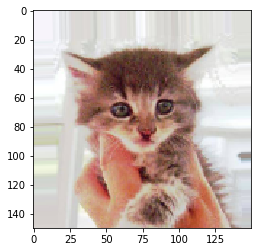

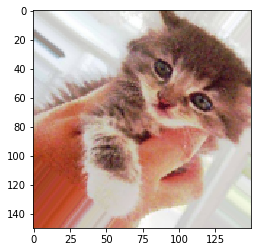

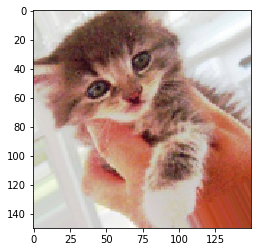

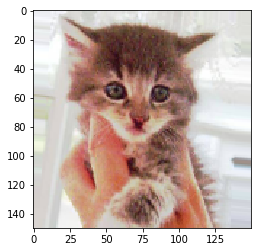

In [22]:
# Module with imagepreprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# Chooses one image to augment
img_path = fnames[3]

# Reads the image and resizes it
img = image.load_img(img_path, target_size=(150, 150))

# Converts it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshapes it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If you train a new network using this data-augmentation configuration, the network will never see the same input twice. But the inputs it sees are still heavily __intercorrelated__, because they come from a small number of original images—you can’t produce new information, you can only remix existing information. As such, this may not be enough to completely get rid of overfitting. To further fight overfitting, you’ll also add a Dropout layer to your model, right before the densely connected classifier.

In [23]:
# Defining a new convnet that includes dropout
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Let’s train the network using data augmentation and dropout.

In [24]:
# Training the convnet using data-augmentation generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Note that the validation data shouldn’t be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 110s 1s/step - loss: 0.6892 - acc: 0.5291 - val_loss: 0.6720 - val_acc: 0.5400
Epoch 2/100
100/100 [==============================] - 108s 1s/step - loss: 0.6731 - acc: 0.5644 - val_loss: 0.6680 - val_acc: 0.5664
Epoch 3/100
100/100 [==============================] - 111s 1s/step - loss: 0.6589 - acc: 0.5981 - val_loss: 0.6483 - val_acc: 0.6041
Epoch 4/100
100/100 [==============================] - 112s 1s/step - loss: 0.6407 - acc: 0.6169 - val_loss: 0.6413 - val_acc: 0.6063
Epoch 5/100
100/100 [==============================] - 111s 1s/step - loss: 0.6239 - acc: 0.6488 - val_loss: 0.6121 - val_acc: 0.6574
Epoch 6/100
100/100 [==============================] - 114s 1s/step - loss: 0.6159 - acc: 0.6600 - val_loss: 0.6188 - val_acc: 0.6508
Epoch 7/100
100/100 [==============================] - 111s 1s/step - loss: 0.6006 - acc: 0.6688 - val_loss: 0.5

100/100 [==============================] - 113s 1s/step - loss: 0.4118 - acc: 0.8112 - val_loss: 0.4552 - val_acc: 0.8054
Epoch 62/100
100/100 [==============================] - 116s 1s/step - loss: 0.4184 - acc: 0.8078 - val_loss: 0.4437 - val_acc: 0.8008
Epoch 63/100
100/100 [==============================] - 115s 1s/step - loss: 0.3971 - acc: 0.8194 - val_loss: 0.4697 - val_acc: 0.7970
Epoch 64/100
100/100 [==============================] - 120s 1s/step - loss: 0.4023 - acc: 0.8147 - val_loss: 0.4482 - val_acc: 0.7874
Epoch 65/100
100/100 [==============================] - 116s 1s/step - loss: 0.3943 - acc: 0.8244 - val_loss: 0.4177 - val_acc: 0.8065
Epoch 66/100
100/100 [==============================] - 116s 1s/step - loss: 0.3924 - acc: 0.8206 - val_loss: 0.4978 - val_acc: 0.7796
Epoch 67/100
100/100 [==============================] - 116s 1s/step - loss: 0.3826 - acc: 0.8294 - val_loss: 0.4170 - val_acc: 0.8109
Epoch 68/100
100/100 [==============================] - 117s 1s/step

Let’s save the model

In [25]:
model.save('cats_and_dogs_small_2.h5')

And let’s plot the results again. Thanks to data augmentation and dropout, you’re no longer overfitting: the training curves are closely tracking the validation curves. You now reach an accuracy of 82%, a 15% relative improvement
over the non-regularized model.

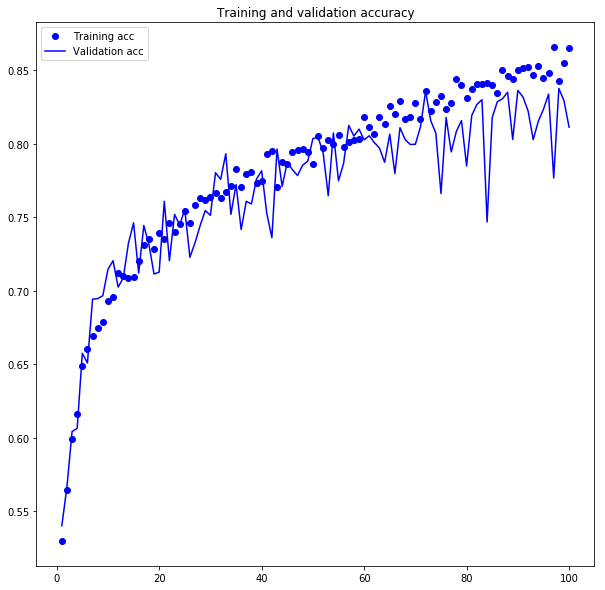

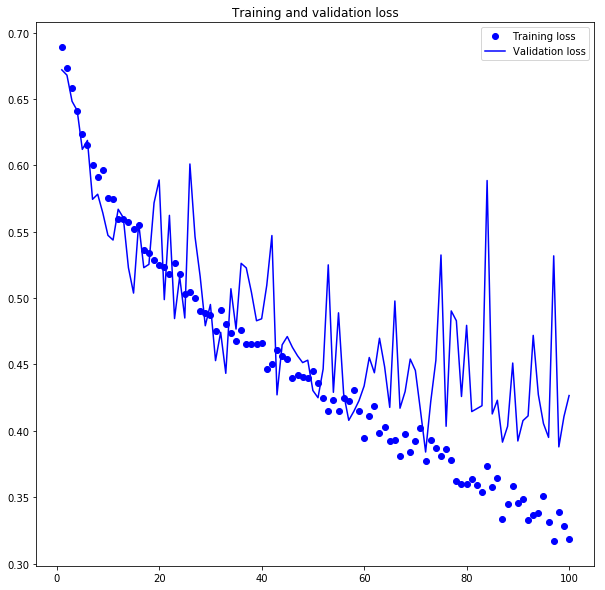

In [26]:
# Displaying curves of loss and accuracy during training
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 10))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(10, 10))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

By using regularization techniques even further, and by tuning the network’s parameters (such as the number of filters per convolution layer, or the number of layers in
the network), you may be able to get an even better accuracy, likely up to 86% or 87%. But it would prove difficult to go any higher just by training your own convnet from
scratch, because you have so little data to work with. As a next step to improve your accuracy on this problem, you’ll have to use a pretrained model, which is the focus of
the next two sections.